# Medical Text Analysis
Introduction: This project employs Natural Language Processing (NLP) techniques to analyze medical text data from the N2C2 database. It involves tasks such as Named Entity Recognition, text preprocessing, word embedding generation, and integration of test data for comprehensive medical text analysis
Goal: The final goal of our analysis is to analyse raw medical text and predict the disease outcome of co-morbid conditions with diabetes such as depression, hypertension, CAD e.t.c.
Reference:

This is the data wrangling portion of the project! We import the data and make it interpretable by a model to predict our results

In [2]:
#Data Handling Libraries
import xmltodict
import nltk
import numpy as np
import re
import collections
import pandas as pd

#URL request library
import requests

#Path Setup Libraries
import os, pathlib, glob
from pathlib import Path

#NLP LIbraries
import nltk, re
from nltk import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk import ngrams, pos_tag, word_tokenize, sent_tokenize
nltk.download('punkt')

#XML Parsing Libraries
import xml.etree.ElementTree as ET

#To work with stop words and puctuations
import string

#Tranformers for Medical Named Entity Recognition and Word Embedding Vectors from huggingface
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

#AutoModel for you word embeddings model
from transformers import AutoTokenizer, AutoModel

#PyTorch for running the ClinicalBert
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pranaypk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\pranaypk\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
#url for the medical test from n2c2
url_text = ""
#url for test data from n2c2
url_test = ""

## Data Retrieval from URL

Fetching medical text data from a URL and converting it into a structured DataFrame.

- Convert XML data to a hierarchical structure for manipulation.
- Iterate through XML to extract 'doc_id' and 'text', storing them in the DataFrame.

In [12]:

response = requests.get(url_text)

if response.status_code == 200:
    xml_data = response.content
    root = ET.fromstring(xml_data)

    df = pd.DataFrame(columns=['doc_id', 'text'])
    for doc in root.findall(".//doc"):
        doc_id = doc.get("id")
        text = doc.find("text").text.strip()
        doc_id = int(doc_id)
        df.loc[len(df)] = [doc_id, text]
else:
    print(f"Failed to fetch data")

df.head()

,doc_id,text
0,1,490646815 | WMC | 31530471 | | 9629480 | 11/23...
1,2,159644670 | VH | 60656526 | | 6334749 | 11/29/...
2,4,368346277 | EMH | 64927307 | | 815098 | 3/29/1...
3,6,018858680 | AOH | 80239131 | | 9725704 | 11/4/...
4,13,908761918 | MMC | 45427009 | | 0927689 | 5/26/...


## Text Preprocessing: Stopword Removal and Tokenization

Performing initial text preprocessing steps on the medical text data.

- Remove tokens that match stopwords to eliminate common non-informative words.
- Remove tokens that are punctuation marks to clean the text further.

In [13]:
#Getting Stop workds
stop = stopwords.words('english')
stop = sorted(stop)

#Tokenizing the text
df['text'] = df['text'].apply(nltk.word_tokenize)

# Remove stopwords
df['text'] = df['text'].apply(lambda x: [token for token in x if token.lower() not in stop])

# Remove punctuations
df['text'] = df['text'].apply(lambda x: [token for token in x if token not in string.punctuation])

df.head()

,doc_id,text
0,1,"[490646815, WMC, 31530471, 9629480, 11/23/2006..."
1,2,"[159644670, VH, 60656526, 6334749, 11/29/2005,..."
2,4,"[368346277, EMH, 64927307, 815098, 3/29/1993, ..."
3,6,"[018858680, AOH, 80239131, 9725704, 11/4/2005,..."
4,13,"[908761918, MMC, 45427009, 0927689, 5/26/2007,..."


## Named Entity Recognition with Pre-trained Model

Utilizing a pre-trained model and tokenizer to extract Named Entities from the medical text.

- Load a pre-trained tokenizer and model specialized for biomedical Named Entity Recognition from hugging face
- Reference: d4data/biomedical-ner-all

In [14]:
#Pre-trained model and tokenizer to get Named Entities from the  text
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

## Extracting Unique Entities from NER Output

Processing the NER output for a sample medical text to extract unique entity categories.

- Get unique entities to help us get a picture of the entities that can be found in the data

In [5]:
#Getting all the unique entity names from one sample mapped NER's
sample_text = ' '.join(df.at[0,'text'])
data = pipe(sample_text)
unique_words = set()

for item in data:
    if 'entity_group' in item:
        unique_words.add(item['entity_group'])

# Convert the set of unique words back to a list
unique_words_list = list(unique_words)

#Unique Entities
print(unique_words_list)

['Date', 'Clinical_event', 'Dosage', 'Detailed_description', 'Therapeutic_procedure', 'Duration', 'Sign_symptom', 'Sex', 'Disease_disorder', 'History', 'Time', 'Coreference', 'Age', 'Medication', 'Lab_value', 'Diagnostic_procedure', 'Nonbiological_location']


## Custom Function for Disease Named Entity Recognition

Defining a custom function to extract Named Entities related to diseases from tokenized text.

- Iterate through the unique entity group names and filters NER results for each group.

In [6]:
#Function to get the Named Entity for tokens of each row (each record)
#Loops through each item to get entity group, score, and the actual word
def disease_named_entity_recognition(row_data):
    table_variables = {}
    string_text = ' '.join(row_data)
    ner = pipe(string_text)
    for i in unique_words_list:
        filtered_ner = [item for item in ner if item.get('entity_group') == i]
        sorted_ner = sorted(filtered_ner, key=lambda x: x['score'], reverse=True)
        just_name = set(item.get('word') for item in sorted_ner)
        table_variables[i] = just_name
    return table_variables

## Applying Disease Named Entity Recognition

Apply the custom disease Named Entity Recognition function to each medical text in the DataFrame.

- Note that running this step might take a significant amount of time on slower hardware.

In [7]:
#This takes time! 5 min in my snail paced laptop!!

#Apply the NER function to each medical text
df['extracted_diseases'] = df['text'].apply(disease_named_entity_recognition)

## Populating Entity Data in New Columns

Filling the newly created entity-specific columns with relevant data from the 'extracted_diseases' column.

- Splitting our dictionary column into a more interpretable seperate columns

In [8]:
#Looping thorpugh the unquie entity list to create new columns in out dataFrame
for group in unique_words_list:
    df[group] = None

#Split our dictiory in the extracted variables column into the multiple columns - The empty ones we just created!
for i, row in df.iterrows():
    extracted_diseases = row['extracted_diseases']
    for group in unique_words_list:
        entity_set = list(extracted_diseases.get(group, set()))
        df.at[i, group] = entity_set

#df.head()


In [9]:
#Function to extract age from the age text - so we can actually perform an analysis on that

def extract_integer_age(age_set):
    for phrase in age_set:
        age_match = re.search(r'\d+', phrase)
        if age_match:
            return int(age_match.group())
    return None


## Cleaning and Categorizing Sex and Age Column

In [10]:
#apply that extract age function through all rows
df['Age'] = df['Age'].apply(extract_integer_age)

#Clean the Sex column and convert into a 2 level categorical value
df['Sex'] = df['Sex'].apply("".join)

#Mapping and pattern for various sex values
gender_patterns = [
    (r'\bwoman\b|\bfemale\b', 'female'),
    (r'\bman\b|\bmale\b', 'male'),
]

for pattern, replacement in gender_patterns:
    df['Sex'] = df['Sex'].apply(lambda x: re.sub(pattern, replacement, x))

#Mapping again!
gender_mapping = {
    'female': 'female',
    'male': 'male',
    'woman': 'female',
    'man': 'male',
    'gentleman': 'male',
    'lady': 'female'
}

# Apply the mapping and if you have no matches, NA it is!
df['Sex'] = df['Sex'].apply(lambda x: gender_mapping.get(x, 'NA'))

#Check the values in the Sex Column now (Should be male, female and NA!)
df['Sex'].unique()

array(['female', 'male', 'NA'], dtype=object)

## Utilizing Bio_ClinicalBert for Word Embeddings

Using the pre-trained Bio_ClinicalBert model and tokenizer from Hugging Face to generate word embedding vectors.

- Load the tokenizer and model for Bio_ClinicalBert from Hugging Face's model repository.
- Reference: Carly's example that uses Bio Clinical Bert from Hugging Face

In [22]:
#Tokenizer and Model from the Bio_ClinicalBert model from HuggingFace

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

#Function to get the word embedding vector. Referenced from Carly's example!

def get_word_embedding(word):
    # Tokenize the word and convert to IDs
    inputs = tokenizer(word, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Pass the input through the model to get embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract embeddings from the output
    word_embedding = outputs.last_hidden_state[:, 0, :]

    return word_embedding[0].numpy()

## Generating Mean Word Embeddings for Categories

Creating mean word embeddings for medical text categories ('Sign_symptom', 'Dosage', 'Medication', 'Disease_disorder') so that we have one value

- Note:  This step may require a substantial amount of time for execution.

In [12]:
############## THIS TAKES FOREEEEEVEEEER TO RUN ############## 40 min in my computer!!######

#Loopthrough the text in each of those columns and get an array of word embeddings
for col in df[['Sign_symptom', 'Dosage', 'Medication', 'Disease_disorder']].columns:
    new_col = f'{col}_mean_embedding'
    df[new_col] = df[col].apply(lambda word_list: np.mean([get_word_embedding(word) for word in word_list], axis=0))

#df.head()

c:\Users\pranaypk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pranaypk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pranaypk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pranaypk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [13]:
#Averaging the word embedd values, to get an overall score

for col in df[['Sign_symptom_mean_embedding', 'Dosage_mean_embedding', 'Medication_mean_embedding', 'Disease_disorder_mean_embedding']].columns:
    df[col] = df[col].apply(np.mean)

In [14]:
#Scale the Values so you can use it to predict the final Cateogory!

columns_to_scale = ['Sign_symptom_mean_embedding', 'Dosage_mean_embedding', 'Medication_mean_embedding', 'Disease_disorder_mean_embedding']

def scale_and_fill_na_with_mean(dataframe):
    column_means = dataframe.mean()
    scaled_df = (dataframe - column_means) / dataframe.std()
    scaled_and_filled_df = scaled_df.fillna(column_means)
    return scaled_and_filled_df

df[columns_to_scale] = scale_and_fill_na_with_mean(df[columns_to_scale])

#df.head()


## Fetching and Integrating Test Data

Retrieving test data and merging it with the main DataFrame so that we can test the accuracy of our model

In [3]:
response = requests.get(url_test)

if response.status_code == 200:
    xml_data = response.content
    root = ET.fromstring(xml_data)
    data = {}
    for disease_elem in root.findall(".//disease"):
        disease_name = disease_elem.get("name")
        doc_data = {}

        for doc_elem in disease_elem.findall(".//doc"):
            doc_id = doc_elem.get("id")
            judgment = doc_elem.get("judgment", "Q")  # Default to "Q" if no judgment attribute
            doc_data[doc_id] = judgment

        data[disease_name] = doc_data

    test_df = pd.DataFrame(data)
    test_df['doc_id'] = test_df.index
else:
    print(f"Failed to fetch data")

In [16]:
#Inner Join it with the main dataFrame with doc_id as the key

df[['doc_id']] = df[['doc_id']].astype(int)
test_df[['doc_id']] = test_df[['doc_id']].astype(int)
merged_df = pd.merge(df, test_df, on="doc_id" ,how="inner")

In [22]:
# My Final Data Set. Yaaaayyyyyyy!
# Get columns that are necassary
columns_needed = ['doc_id','Age','Sex','Sign_symptom_mean_embedding',
       'Dosage_mean_embedding', 'Medication_mean_embedding',
       'Disease_disorder_mean_embedding', 'Asthma', 'CAD', 'CHF', 'Depression',
       'Diabetes', 'Gallstones', 'GERD', 'Gout', 'Hypercholesterolemia',
       'Hypertension', 'Hypertriglyceridemia', 'OA', 'Obesity', 'OSA', 'PVD',
       'Venous Insufficiency']

final_df = merged_df[columns_needed]

## The Final Data frame - Yaay!

In [28]:
final_df

,doc_id,Age,Sex,Sign_symptom_mean_embedding,Dosage_mean_embedding,Medication_mean_embedding,Disease_disorder_mean_embedding,Asthma,CAD,CHF,...,GERD,Gout,Hypercholesterolemia,Hypertension,Hypertriglyceridemia,OA,Obesity,OSA,PVD,Venous Insufficiency
0,3,57.0,female,-0.135360,0.160407,-0.359768,0.300799,Y,Y,Y,...,N,N,Y,Y,N,Y,NaN,Y,Y,N
1,5,64.0,male,0.109368,-0.007173,-0.006882,0.240273,N,Y,NaN,...,NaN,N,Y,Y,NaN,N,NaN,N,NaN,N
2,7,56.0,female,-0.052523,-0.321604,-0.332040,-0.226017,N,N,Y,...,N,N,N,N,N,N,Y,N,N,N
3,8,NaN,female,-0.301072,-0.042164,-0.141801,-0.472457,NaN,NaN,Y,...,Y,N,N,NaN,N,N,NaN,Y,N,N
4,9,NaN,NA,-1.159010,1.006911,-0.619233,-0.006763,Y,N,NaN,...,Y,N,Y,Y,N,NaN,NaN,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,1228,52.0,male,-0.259325,0.214659,-0.494626,-0.783657,N,Y,Y,...,N,N,N,N,N,N,NaN,N,N,N
503,1230,62.0,female,-0.126740,0.376808,-0.102933,-0.488200,N,Y,N,...,N,N,Y,N,N,N,N,N,N,N
504,1231,62.0,female,-0.073993,-0.007173,-0.704967,-0.556493,Y,NaN,Y,...,NaN,N,Y,Y,N,Y,Y,Y,N,NaN
505,1241,63.0,female,0.140653,0.341176,-0.828622,-1.316808,N,Y,N,...,N,N,Y,Y,N,N,NaN,N,N,NaN


Write the results into a CSV

In [30]:
final_df.to_csv(r'../data/output_finaldf.csv', index = False)

## Proceed next to the Data_model file to run the model with this cleaned and wrangled data!!

## Extra: Create a network diagram: if the person has a the co-mordid disease with Diabetes, map their diagnosis with their strenght of word embedding values

In [17]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

final_df = pd.read_csv("../data/output_finaldf.csv")

In [25]:
all_diseases = pd.DataFrame(columns=['disease', 'embeddings'])
all_diseases['disease'] = pd.Series(["Asthma", "CAD", "CHF", "Depression", "Diabetes", 
                      "Gallstones", "GERD", "Gout", "Hypercholesterolemia",
                      "Hypertension", "Hypertriglyceridemia", "OA", 
                      "Obesity", "OSA", "PVD", "Venous Insufficiency"])

all_diseases['embeddings'] = all_diseases['disease'].apply(get_word_embedding)

## Network diagram generation

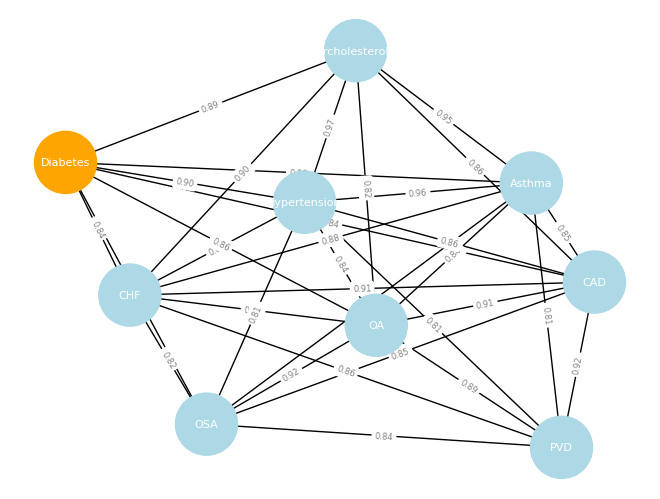

<Figure size 1000x600 with 0 Axes>

In [47]:
embeddings_df = pd.DataFrame(all_diseases)

selected_doc_id = 3

# Filter the data for the selected doc_id
selected_row = final_df[final_df["doc_id"] == selected_doc_id]

G = nx.Graph()

highlight_disease = "Diabetes" 
for _, row in embeddings_df.iterrows():
    disease = row["disease"]
    embedding = row["embeddings"]
    if disease in selected_row.columns and selected_row[disease].values[0] == "Y":
        G.add_node(disease, embedding=embedding, highlighted=disease == highlight_disease)

# Calculate cosine similarity between embeddings and add edges (with higher threshold)
similarity_threshold = 0.8  #specifying a threshold
for disease1 in G.nodes():
    for disease2 in G.nodes():
        if disease1 != disease2:
            embedding1 = G.nodes[disease1]["embedding"]
            embedding2 = G.nodes[disease2]["embedding"]
            similarity = cosine_similarity([embedding1], [embedding2])[0][0]
            if similarity > similarity_threshold:
                G.add_edge(disease1, disease2, weight=similarity)



# graph
pos = nx.spring_layout(G, seed=42)
node_colors = ["lightblue" if not data["highlighted"] else "orange" for _, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, font_color="white", node_color=node_colors)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="gray", font_size=6)

plt.figure(figsize=(10, 6))
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'

plt.show()